In [10]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os


import warnings
warnings.filterwarnings("ignore")

In [5]:
## Define params and helpera

In [50]:
# Define params and helpers
xlsx_path = './ODIR_dataset/ODIR-5K_Training_Annotations(Updated)_V2.xlsx'
data_dir = './ODIR_dataset/ODIR-5K_Training_Dataset/'

classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
left_classes = ['N', 'D', 'G', 'C',]
right_classes = ['A', 'H', 'M', 'O']
img_size = (160, 160)

In [41]:
df = pd.read_excel(xlsx_path)
df[:5]

FileNotFoundError: [Errno 2] No such file or directory: './ODIR_dataset/ODIR-5K_Training_Annotations(Updated)_V2.xlsx'

In [42]:
def get_input(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return(img)

In [49]:
def get_output(df):
    left_labels = df[left_classes].values.tolist()
    right_labels = df[right_classes].values.tolist()
    return (left_labels), (right_labels)

In [44]:
def preprocess_input(image):
    img_resized = cv2.resize(image, img_size)
    return(img_resized)

In [45]:
def image_generator(df, batch_size=64):
    df = df.sample(frac=1).reset_index(drop=True)
    img_path_left_list = df['Left-Fundus'].values.tolist()
    img_path_right_list = df['Right-Fundus'].values.tolist()
    left_labels, right_labels = get_output(df[classes])
    n_data = len(df)
    count = 0
    
    while True:
        # Select files (paths/indices) for the batch
        
        batch_input_left = []
        batch_input_right = []
        batch_output_left = [] 
        batch_output_right = []
          
        # Read in each input, perform preprocessing and get labels
        for i in range(batch_size):
            idx = count % n_data
            img_path_left = os.path.join(data_dir, img_path_left_list[idx])
            img_path_right = os.path.join(data_dir, img_path_right_list[idx])
            input_left = get_input(img_path_left)
            input_right = get_input(img_path_right)
            left_output = left_labels[idx]
            right_output = right_labels[idx]
            
            input_left = preprocess_input(image=input_left)
            input_right = preprocess_input(image=input_right)
            batch_input_left += [input_left]
            batch_input_right += [input_right]
            batch_output_left += [left_output]
            batch_output_right += [right_output]
        # Return a tuple of (input,output) to feed the network
        batch_x_left = np.array(batch_input_left)
        batch_x_right = np.array(batch_input_right)
        batch_y_left = np.array(batch_output_left)
        batch_y_right = np.array(batch_output_right)
        
        yield([batch_x_left, batch_x_right], [batch_y_left, batch_y_right] )

In [46]:
def create_model():
    # left head
    base_model_shared = ResNet50(include_top=False, pooling='avg', weights='imagenet')
    for layer in base_model_shared.layers:
        layer._name = layer.name + '_r'
        layer.trainable = False
        
    input_left = keras.layers.Input(shape=(160, 160, 3, ))
    left_out = base_model_shared(input_left)
    x_l = keras.layers.Dropout(0.2)(left_out)
    x_l = keras.layers.Dense(512)(x_l)
    x_l = keras.layers.BatchNormalization()(x_l)
    x_l = keras.layers.Activation('relu')(x_l)
    x_l = keras.layers.Dense(512)(x_l)
    x_l = keras.layers.BatchNormalization()(x_l)
    x_l = keras.layers.Activation('relu')(x_l)
    x_l = keras.layers.Dropout(0.2)(x_l)
    out_l = keras.layers.Dense(len(left_classes) // 2, activation='sigmoid')(x_l)
    
    input_right = keras.layers.Input(shape=(160, 160, 3, ))
    right_out = base_model_shared(input_right)
    x_r = keras.layers.Dropout(0.2)(right_out)
    x_r = keras.layers.Dense(512)(x_r)
    x_r = keras.layers.BatchNormalization()(x_r)
    x_r = keras.layers.Activation('relu')(x_r)
    x_r = keras.layers.Dense(512)(x_r)
    x_r = keras.layers.BatchNormalization()(x_r)
    x_r = keras.layers.Activation('relu')(x_r)
    x_r = keras.layers.Dropout(0.2)(x_r)
    out_r = keras.layers.Dense(len(right_classes) // 2, activation='sigmoid')(x_r)
    model = keras.models.Model(inputs=[input_left, input_right], outputs=[out_l, out_r])
    return model

In [47]:
model = create_model()
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
input_25 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Model)                (None, 2048)         23587712    input_24[0][0]                   
                                                                 input_25[0][0]                   
__________________________________________________________________________________________________
dropout_26 (Dropout)            (None, 2048)         0           resnet50[1][0]             

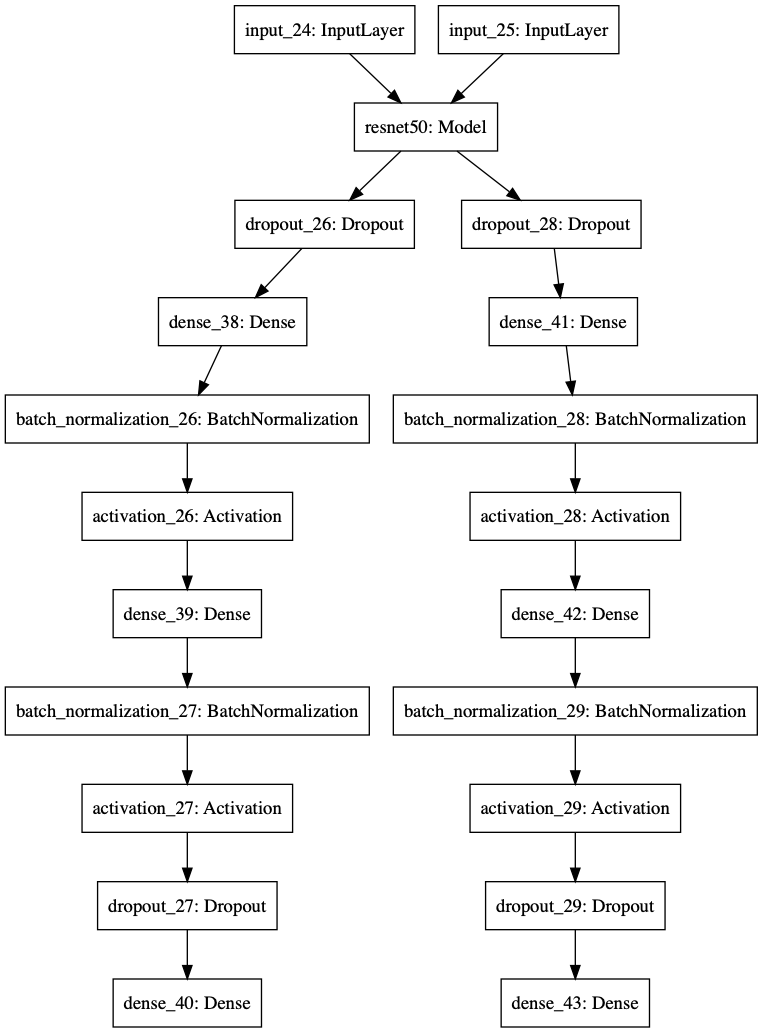

In [48]:
plot_model(model, to_file='2_pretrained_model_and_1_classifier.png')